In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
years = 5
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days = 365*years)

In [3]:
tickers = ['SPY','BND','GLD','QQQ','VTI']

In [4]:
adj_close = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker,start = startDate,end = endDate)
    adj_close[ticker] = data['Adj Close']

print(adj_close)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
                   SPY        BND         GLD         QQQ         VTI
Date                                                                 
2018-10-10  256.016693  68.507523  112.879997  166.113174  131.171295
2018-10-11  250.377518  68.701180  115.779999  164.052856  128.374390
2018-10-12  253.854919  68.683586  115.230003  168.618469  130.067261
2018-10-15  252.428909  68.665970  116.000000  166.577499  129.487610
2018-10-16  257.948608  68.718781  115.800003  171.423584  132.339813
...                ...        ...         ...         ...         ...
2023-10-02  427.309998  69.110001  169.649994  361.260010  212.130005
2023-10-03  421.589996  6

In [5]:
log_returns = np.log(adj_close/adj_close.shift(1))
log_returns = log_returns.dropna()

print(log_returns)

                 SPY       BND       GLD       QQQ       VTI
Date                                                        
2018-10-11 -0.022273  0.002823  0.025367 -0.012481 -0.021553
2018-10-12  0.013793 -0.000256 -0.004762  0.027450  0.013101
2018-10-15 -0.005633 -0.000257  0.006660 -0.012178 -0.004467
2018-10-16  0.021631  0.000769 -0.001726  0.028677  0.021788
2018-10-17  0.000178 -0.001795 -0.000086  0.000395 -0.000278
...              ...       ...       ...       ...       ...
2023-10-02 -0.000398 -0.006893 -0.010554  0.008311 -0.001319
2023-10-03 -0.013476 -0.008136 -0.002892 -0.017705 -0.014626
2023-10-04  0.007256  0.006543 -0.000118  0.013517  0.007197
2023-10-05 -0.000377  0.000724 -0.001834 -0.002951 -0.000523
2023-10-06  0.011803 -0.003918  0.005140  0.016617  0.011856

[1255 rows x 5 columns]


In [6]:
portofolio_value = 100000
# This line creates an array of equal weights for each ticker in the list 'tickers'
weights = np.array([1/len(tickers)]*len(tickers))
print(weights)

[0.2 0.2 0.2 0.2 0.2]


In [7]:
historical_returns = (log_returns * weights).sum(axis =1)
print(historical_returns)

Date
2018-10-11   -0.005623
2018-10-12    0.009865
2018-10-15   -0.003175
2018-10-16    0.014228
2018-10-17   -0.000317
                ...   
2023-10-02   -0.002171
2023-10-03   -0.011367
2023-10-04    0.006879
2023-10-05   -0.000992
2023-10-06    0.008300
Length: 1255, dtype: float64


In [8]:
days = 5

historical_x_day_returns = historical_returns.rolling(window = days).sum()

In [9]:
cov_matrix = log_returns.cov()* 252
cov_matrix

,SPY,BND,GLD,QQQ,VTI
SPY,0.046485,0.002392,0.003121,0.052854,0.047476
BND,0.002392,0.004307,0.003653,0.002969,0.002531
GLD,0.003121,0.003653,0.021816,0.004519,0.003284
QQQ,0.052854,0.002969,0.004519,0.069017,0.053942
VTI,0.047476,0.002531,0.003284,0.053942,0.048861


In [10]:
portofolio_std_dev = np.sqrt(weights.T @cov_matrix @weights)
portofolio_std_dev

0.1475085027247076

In [12]:
confidence_levels = [.9,.95,.99]

In [13]:
VaRs = []
for cl in  confidence_levels:
    VaR = portofolio_value * portofolio_std_dev * norm.ppf(cl) *np.sqrt(days/252)
    VaRs.append(VaR)
    

In [18]:
print(f'{"Confidence Level":<20}{"Value at Risk":<20}')
print('-'*40)

for cl , VaR in zip(confidence_levels,VaRs):
    print(f'{cl *100 :>.0f}%:      {"":8} ${VaR:>10,.2f}')

Confidence Level    Value at Risk       
----------------------------------------
90%:               $  2,662.80
95%:               $  3,417.66
99%:               $  4,833.66


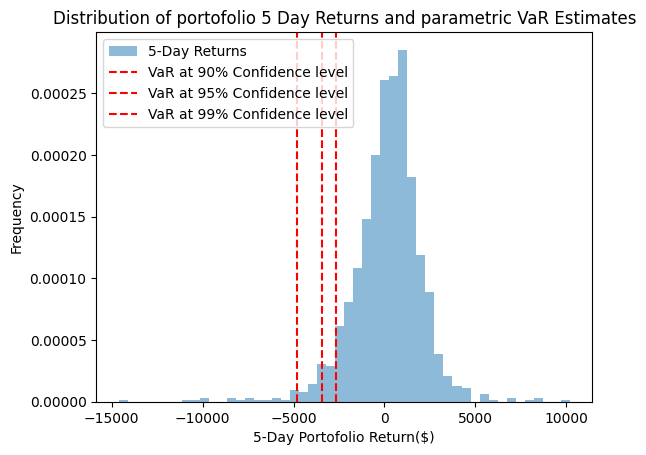

In [19]:
historical_x_day_returns_dollar = historical_x_day_returns * portofolio_value

plt.hist(historical_x_day_returns_dollar,bins=50,density=True,alpha=.5,label=f'{days}-Day Returns')
for cl,VaR in zip(confidence_levels,VaRs):
    plt.axvline(x=_-VaR,linestyle='--',color='r',label='VaR at {}% Confidence level'.format(int(cl *100)))

plt.xlabel(f'{days}-Day Portofolio Return($)')
plt.ylabel('Frequency')
plt.title(f'Distribution of portofolio {days} Day Returns and parametric VaR Estimates')
plt.legend()
plt.show()
                